In [1]:
import os
import io
import re
import sys
import json
import math
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt


def true_round(value):
    """
    Perform rounding as taught in school, i.e., rounding to nearest integer 
    without considering it's odd or even.
    """
    return np.floor(value + 0.5).astype(int) if value >= 0 else np.ceil(value - 0.5).astype(int)


def print_array_info(arr_list, name_list=None, compute_stat=False):
    if not isinstance(arr_list, (list, tuple)):
        arr_list = [arr_list]
    
    name_list = [i for i in range(len(arr_list))] if name_list is None else name_list
    for i in range(len(arr_list)):
        arr = arr_list[i]
        if hasattr(arr, 'min') and hasattr(arr, 'max') and hasattr(arr, 'shape'):
            min_val, max_val = arr.min(), arr.max()
            if hasattr(min_val, 'item'):
                min_val = min_val.item()
            if hasattr(max_val, 'item'):
                max_val = max_val.item()

            val_range = max_val-min_val
            shape = tuple(arr.shape)

            if compute_stat:
                mean_val = arr.mean()
                std_val = arr.std()
                msg = f'INFO {name_list[i]}: shape={shape}, [min,max]=[{min_val:.4f},{max_val:.4f}], range={val_range:.4f}, mean={mean_val:.4f}, std={std_val:.4f}.'
            else:
                msg = f'INFO {name_list[i]}: shape={shape}, [min,max]=[{min_val:.4f},{max_val:.4f}], range={val_range:.4f}.'

        else:
            msg = f'INFO {name_list[i]}: Not an array, type {type(arr)}.'
        
        print(msg)


def stable_linear_transform(x, y_min=0, y_max=1, x_min=None, x_max=None, do_clip=True):
    x_min = x.min() if x_min is None else x_min
    x_max = x.max() if x_max is None else x_max

    if do_clip:
        x = x.clip(x_min, x_max) if hasattr(x, 'clip') else max(min(x, x_max), x_min)

    x_normalized = (x - x_min) / (x_max - x_min)
    y = y_min + (y_max - y_min) * x_normalized
    return y


class DotDict:
        def __init__(self, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, dict):
                    value = DotDict(value)  # Recursively convert nested dictionaries
                setattr(self, key, value)

def show_multiple_images(
    images, 
    nrows=1, 
    ncols=None, 
    titles=None, 
    suptitle=None, 
    tight=True, 
    cmaps='gray', 
    figsize=None, 
    fontsize=12,
    dpi=None, 
    masks=None,
    set_axis_off=True,
    return_pil=False,
    vmin=None,
    vmax=None
):

    num_imgs = len(images)
    ncols = true_round(num_imgs / nrows) if ncols is None else ncols
    num_plots = int(nrows * ncols)
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (tuple, list)) else cmaps
    masks = [masks] * num_imgs if not isinstance(masks, (tuple, list)) else masks
    titles = [titles] * num_imgs if not isinstance(titles, (tuple, list)) else titles
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i in range(num_imgs):
        if isinstance(images[i], torch.Tensor):
            img = images[i].cpu().squeeze()
        elif isinstance(images[i], np.ndarray):
            img = images[i].squeeze()
        elif isinstance(images[i], Image.Image):
            img = np.array(images[i]).squeeze()
        else:
            img = images[i]
        
        mask = masks[i]
        if mask is not None:
            img[mask == 0] = img.min()
        axes[i].imshow(img, cmap=cmaps[i], vmin=vmin, vmax=vmax)
        if set_axis_off:
            axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i], fontsize=fontsize)
    
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=fontsize+1)
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
            
    if tight:
        fig.tight_layout()
    
    if return_pil:
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=dpi)
        buf.seek(0)
        pil_image = Image.open(buf).convert('RGB')
        buf.close()
        plt.close(fig)  # Close the figure to free memory
        return pil_image
    
    return None


# Model Loading

In [2]:
from models.meditok import MedITok

args = DotDict(dict(
    embed_dim=768,
    num_query=0,
    model='vitamin_large',
    img_size=256,
    drop_path=0,
    vocab_size=32768,
    vocab_width=64,
    vocab_norm=True,
    vq_beta=0.25,
    le=0.0,  # VQ entropy loss weight
    e_temp=0.01,
    num_codebooks=8,
    quant_proj='attn',
    grad_ckpt=True,
    device='cpu'
))

net = MedITok(args)
ckpt_path = 'ckpts/meditok_simple_v1.pth'
state_dict = torch.load(ckpt_path, map_location='cpu')
net.load_state_dict(state_dict)
net = net.eval()

/opt/conda/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No pretrained configuration specified for vitamin_large model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for vitamin_large model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


# Inference Demo

/opt/conda/envs/llava/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/envs/llava/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


INFO input: shape=(1, 3, 256, 256), [min,max]=[-1.0000,0.9608], range=1.9608.
INFO recon: shape=(1, 3, 256, 256), [min,max]=[-1.0000,0.9484], range=1.9484.
INFO feature: shape=(1, 768), [min,max]=[-146.6020,79.4756], range=226.0777.


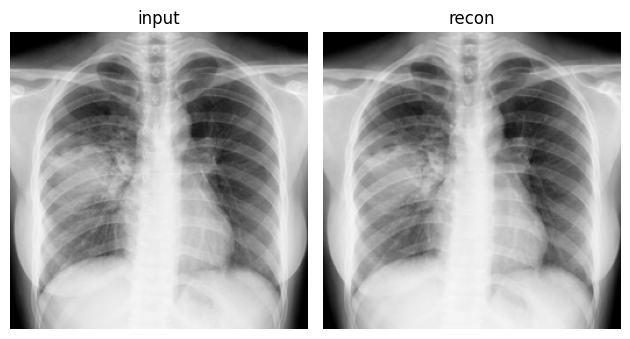

In [3]:
def read_image(img):
    if isinstance(img, str):
        img = Image.open(img)
    if isinstance(img, Image.Image):
        img = img.convert('RGB').resize((256, 256), Image.LANCZOS)
    return img

def image_to_tensor(x):
    # [H, W, C] -> [B, C, H, W]
    x = torch.FloatTensor(np.array(x)).permute(2, 0, 1)
    x = stable_linear_transform(x, x_min=0, x_max=255, y_min=-1, y_max=1)
    return x.unsqueeze(0)

def tensor_to_image(x):
    # [B, C, H, W] -> [H, W, C]
    x = x.clip(-1, 1).squeeze(0).permute(1, 2, 0)
    x = stable_linear_transform(x, x_min=-1, x_max=1, y_min=0, y_max=255)
    x = x.numpy().astype(np.uint8)
    return Image.fromarray(x)


img_path = 'assets/sample1.png'
img = read_image(img_path)
x = image_to_tensor(img)
with torch.no_grad():
    y = net.img_to_reconstructed_img(x)
    f = net.encode_image(x)

print_array_info([x, y, f], name_list=['input', 'recon', 'feature'])
rec = tensor_to_image(y)

show_multiple_images([img, rec], titles=['input', 'recon'])